[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)
[<img src='https://github.com/neuromorphs/tonic/blob/develop/docs/_static/tonic-logo-white.png?raw=true' width="200">](https://github.com/neuromorphs/tonic/)


# Training on ST-MNIST with Tonic + snnTorch

##### By:
#### Dylan Louie (djlouie@ucsc.edu),
####Hannah Cohen Sandler (hcohensa@ucsc.edu),
####Shatoparba Banerjee (sbaner12@ucsc.edu)
##### Credits to our Professor: Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://https://colab.research.google.com/drive/17lDMQYpEjA_oD-VmIG__qTlv1EdV9tjY#scrollTo=0PD5VPOUr4bs&uniqifier=1">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


For a comprehensive overview on how SNNs work, and what is going on under the hood, [then you might be interested in the snnTorch tutorial series available here.](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)
The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

In [98]:
!pip install tonic --quiet
!pip install snntorch --quiet

In [99]:
import tonic
import tonic.transforms as transforms  # Not to be mistaken with torchdata.transfroms
from tonic import DiskCachedDataset
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
import snntorch.spikeplot as splt
from snntorch import functional as SF
from snntorch import utils
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
import numpy as np
import torchdata
import os
from ipywidgets import IntProgress
import time

# 1. STMNIST

## 1.1 A Description

The Spiking Tactile-MNIST (ST-MNIST) dataset is a novel neuromorphic collection featuring handwritten digits (0-9) inscribed by 23 individuals on a 100-taxel biomimetic event-based tactile sensor array. This dataset, publicly available to facilitate research in tactile perception, captures the dynamic pressure changes associated with natural writing. The tactile sensing system, Asynchronously Coded Electronic Skin (ACES), emulates the human peripheral nervous system, transmitting fast-adapting (FA) responses as asynchronous electrical events.

More information about the ST-MNIST dataset can found by the paper written by its authors:

> <cite> H. H. See, B. Lim, S. Li, H. Yao, W. Cheng, H. Soh, and B. C. K. Tee, "ST-MNIST - The Spiking Tactile-MNIST Neuromorphic Dataset," A PREPRINT, May 2020. [Online]. Available: https://arxiv.org/abs/2005.04319 </cite>



##1.2 Download the STMNIST dataset

The data of ST-MNIST is provided with the MAT format. We are working in Python, so we need a way to import that MAT data into Python. Luckily, Tonic has created a function that creates an IterDataPipe that reads out and transforms the data into an (x, y, t, p) format when provided a path to it. (More down below)

The first thing you must do is download the compressed dataset by accessing: https://scholarbank.nus.edu.sg/bitstream/10635/168106/2/STMNIST%20dataset%20NUS%20Tee%20Research%20Group.zip

The zip file that you download will be titled `STMNIST dataset NUS Tee Research Group`. You must create a folder/directory titled `STMNIST` and then put that zip file in the folder/directory. This will be necessary for the Tonic class we use later.

You then must either put it somewhere you can provide a path to it on your local machine or your Google Drive. For the purposes of this tutorial we will assume Google Drive.

## 1.3 Mount to Drive
Assuming you now have the `STMNIST` directory containing the zip file somewhere in your Google Drive. We must now "mount" Google Drive to this notebook so that it can access it. This is done with the code below:

In [100]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here is the path to the file in our drive, change it to where it is in yours

In [101]:
# After executing the cell above, Drive files will be present in "/content/drive/My Drive".
# Here is the path to the file in our drive, change it to where it is in yours
root = "/content/drive/My Drive/STMNIST_Tutorial"  # similar to os.path.join('drive', 'My Drive', 'Finalized_STMNIST')

The following cell blocks is to make sure you edited the above path correctly. If you get a `FileNotFoundError: [Errno 2] No such file or directory:` error or a `ls: cannot access '/content/drive/My Drive/the/path/you/put/in': No such file or directory` error that means you didn't edit the above path correctly and you are pathing to a directory that doesn't exist. Furthermore make sure  that the directory STMNIST (which you made and has your zip file is in) is in the directory you are pathing to.

In [105]:
# Make sure that the folder STMNIST (which your zip file is in) is in the folder the path directs to way 1
os.listdir(root)  # same as os.listdir("/content/drive/My Drive/STMNIST_Tutorial")

['STMNIST', 'ST-MNIST_Tutorial_with_snnTorch_and_Tonic.ipynb']

In [106]:
# Make sure that the folder STMNIST (which your zip file is in) is in the folder the path directs to way 2
!ls "/content/drive/My Drive/STMNIST_Tutorial"

STMNIST  ST-MNIST_Tutorial_with_snnTorch_and_Tonic.ipynb


## 1.4 ST-MNIST through Tonic
Now we call the `tonic` function to create the class that returns a IterDataPipe of the dataset. The docs for that function can be found here: https://tonic.readthedocs.io/en/latest/generated/tonic.prototype.datasets.STMNIST.html#tonic.prototype.datasets.STMNIST

In [107]:
dataset = tonic.prototype.datasets.STMNIST(root=root,
                                           keep_compressed = False, shuffle = False)

Because the dataset is an IterDataPipe, it can not be indexed into. Instead, we use `next(iter())` in order to iterate through it.

In the above code `dataset` has been set to the returned DataPipe, so now I will just refer to `dataset`. Tonic formats the STMNIST dataset into an `(x, y, t, p)` format just like its other datasets so that the data will be compatable with other parts of its library. Where `x` is the position on the x-axis, `y` is the position on the y-axis, `t` is a timestamp, and `p` is polarity (1 or 0).

Each iteration of dataset returns a tuple. The first index of the tuple contains a numpy array of `(x, y, t, p)` tuples which represents a series of sparse matrix through time of the recordings on the tactile sensor. The second index is a integer 0-9 which is the "label" of the data representing what number the afformentioned events is a drawing of.

In [108]:
print(type(dataset))
events, target = next(iter(dataset))
print(type(events))
print(len(events))
print(events[0])
print(target)

<class 'tonic.prototype.datasets.stmnist.STMNIST'>
<class 'numpy.ndarray'>
4389
(2, 3, 199891, 0)
8


Now that the data is out of the MAT file and into the (x,y,t,p) format we now need it to be in a form that our neural network can read. Luckily Tonic has transformations that do that for us as its other datasets use the (x,y,t,p) format. When you run the code below, the `.ToFrame()` function from `tonic.transforms` changes it from an (x,y,t,p) format to a numpy array matrix.

In [42]:
sensor_size = tuple(tonic.prototype.datasets.STMNIST.sensor_size.values())  # The sensor size for STMNIST is (10, 10, 2) btw
# transforms is the same as tonic.transforms check the imports above if you want to make sure
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

copy_events = frame_transform(events)
print('----------------------------')
print(type(copy_events))
print('----------------------------')
print(len(copy_events))
print('----------------------------')
print(type(copy_events[0]))
print('----------------------------')
print(len(copy_events[0]))
print('----------------------------')
print(copy_events[0])
print('----------------------------')
print(type(copy_events[0][0]))
print('----------------------------')
print(len(copy_events[0][0]))
print('----------------------------')
print(copy_events[0][0])
print('----------------------------')
print(type(copy_events[0][0][0]))
print('----------------------------')
print(len(copy_events[0][0][0]))
print('----------------------------')
print(copy_events[0][0][0])
print('----------------------------')
print(type(copy_events[0][0][0][0]))
print('----------------------------')
print(copy_events[0][0][0][0])

----------------------------
<class 'numpy.ndarray'>
----------------------------
1518
----------------------------
<class 'numpy.ndarray'>
----------------------------
2
----------------------------
[[[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 3 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]]
----------------------------
<class 'numpy.ndarray'>
----------------------------
10
----------------------------
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 

### 1.4.1 The advantages of ST-MNIST over N-MNIST
At the time of release, the closest neuromorphic dataset to ST-MNIST was the N-MNIST dataset which used a moving motion-sensing event-based camera on static images of the original MNIST set (2-d digit classification) to simulate movement. What makes the ST-MNIST dataset better is that the dataset is actually taken from people writing on 10 by 10 tactile pixel sensors. That means when a neural network learns from a dataset it actually has to look at it temporally rather than purely spatially. In N-MNIST every frame would have the digit fully shown, however, for ST-MNIST it only shows parts of it as the participants write over it. That means that as a neuromorphic dataset taking advantage of the spiking and temporal benefits of a SNN ST-MNIST is better than N-MNIST.


Using `tonic.utils.plot_animation`, the frame transform, and also some rotation. We can create an animation of the data and visualize this.

In [43]:
# Iterate to a new iteration
events, target = next(iter(dataset))

Animation of ST-MNIST
The target label is: 0


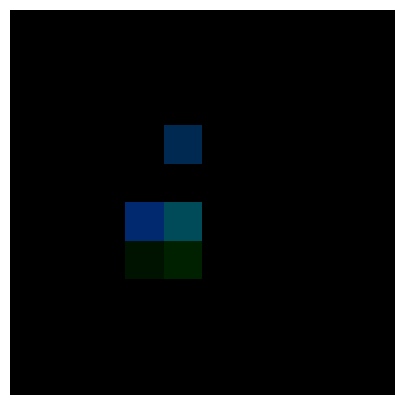

In [44]:
from IPython.display import HTML

frame_transform_tonic_visual = tonic.transforms.ToFrame(
    sensor_size=(10, 10, 2),
    time_window=90000,
)

frames = frame_transform_tonic_visual(events)
frames = frames / np.max(frames)
frames = np.rot90(frames, k=-1, axes=(2, 3))
frames = np.flip(frames, axis=3)

# Print out the Target
print('Animation of ST-MNIST')
print('The target label is:',target)
animation = tonic.utils.plot_animation(frames)

# Display the animation inline in a Jupyter notebook
HTML(animation.to_jshtml())

We can also use `snntorch.spikeplot`

Animation of ST-MNIST
The target label is: 0


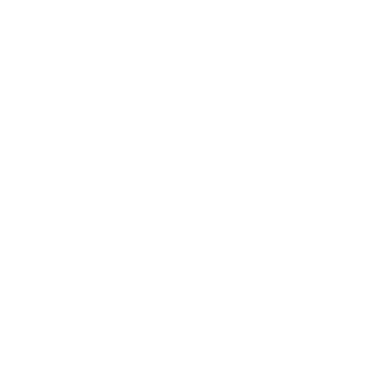

In [45]:
frame_transform_snntorch_visual = tonic.transforms.ToFrame(
    sensor_size=(10, 10, 2),
    time_window=8000,
)

tran = frame_transform_snntorch_visual(events)
tran = np.rot90(tran, k=-1, axes=(2, 3))
tran = np.flip(tran, axis=3)
tran = torch.from_numpy(tran)

tensor1 = tran[:, 0:1, :, :]
tensor2 = tran[:, 1:2, :, :]

print('Animation of ST-MNIST')
print('The target label is:',target)

fig, ax = plt.subplots()
time_steps = tensor1.size(0)
tensor1_plot = tensor1.reshape(time_steps, 10, 10)
anim = splt.animator(tensor1_plot, fig, ax, interval=10)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

display(HTML(anim.to_html5_video()))

In [46]:
nmnist_sensor_size = tonic.datasets.NMNIST.sensor_size
nmnist_frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=nmnist_sensor_size,
                                                         time_window=3000)
                                     ])

nmnist_dataset = tonic.datasets.NMNIST(save_to='./tmp/nmnist_example_data', transform=nmnist_frame_transform, train=False)

In [47]:
nmnist_events, nmnist_target = nmnist_dataset[0]

Animation of N-MNIST
The target label is: 8


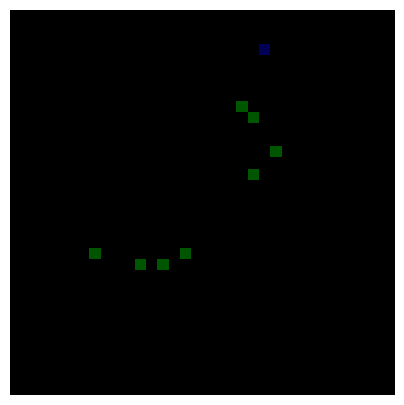

In [48]:
# Print out the Target
print('Animation of N-MNIST')
print('The target label is:',nmnist_target)
# normalize values to between 0-1
nmnist_events_fraction = nmnist_events / np.max(nmnist_events)
animation = tonic.utils.plot_animation(nmnist_events_fraction)
# Display the animation inline in a Jupyter notebook
HTML(animation.to_jshtml())

A printout of the sensor size of the ST-MNIST and N-MNIST dataset. (10, 10, 2) menas a 10 by 10 pixel dataset with a channel size of 2. (34, 34, 2) means a 34 by 34 pixel dataset with a channel size of 2.

In [49]:
print('STMNIST', tonic.prototype.datasets.STMNIST.sensor_size)
print('NMNIST', tonic.datasets.NMNIST.sensor_size)

STMNIST {'x': 10, 'y': 10, 'p': 2}
NMNIST (34, 34, 2)


There is a total of 6953 recordings in this dataset. This lines up with what is said in the ST-MNIST paper. They invited in 23 participants to write around 30 times each for 9 digits.

In [50]:
print(len(dataset)) # 23 participants writing around 30 times each for 9 digits 23*30*9 = 6210

6953


##1.5 Lets create a trainset and testset!

Unfortunately unlike N-MNIST, ST-MNIST isn't already seperated into a trainset and testset on tonic. That means we will have to seperate that manually. For this example you could do 80% of the dataset for the trainset and 20% for the testset which we calculate below.

In [51]:
# Calculate the sizes for the training and testing sets
total_size = len(dataset)
print(total_size)
# train_size is 80% of total size
train_size = int(0.8 * total_size)
print(train_size)
test_size = total_size - train_size
print(test_size)

6953
5562
1391


In [52]:
sensor_size = tonic.prototype.datasets.STMNIST.sensor_size
sensor_size = tuple(sensor_size.values())

# Define a transform
frame_transform = transforms.Compose([transforms.ToFrame(sensor_size=sensor_size, time_window=1000)])

The following code reads out the entirety of the dataset from the IterDataPipe and then transforms the events using the `frame_transform` above. It also seperates out the data into a trainset and a testset. Remember that each time a piece of data is read out of the datapipe it is read and transformed from the MAT files using tonic. On top of that we are to the .ToFrame() transform over it each time. Thus, this takes some time.

**You have two options here:**

Transform and tain on a small part of the dataset, this is faster and is the default for the sake of a short easy to run tutorial. The default for this shorter transform is 640 pieces of data for the trainset and 320 pieaces of data for the testset. This takes ~4-5 minutes. Feel free to change this, just be aware that the number of pieces of data we transform and the time it takes have an inverse relationship.

**Or** you can transform and convert the entire dataset; this takes ~30-60 minutes. To do that comment out the `shorter_transform_STMNIST` cell block and uncomment the `full_transform_STMNIST` cell block and run that instead. If you choose this: kickback, take a break and eat a snack while this happens. perhaps even count kangaroos to take a nap or do a shoey and get schwasted instead.

Note: A smaller dataset generally means a higher accuracy but less generalizability on new data when training a neural network on it given the same amount of time.

In [53]:
def shorter_transform_STMNIST(data, transform):
    short_train_size = 640
    short_test_size = 320

    train_bar = IntProgress(min=0, max=short_train_size)
    test_bar = IntProgress(min=0, max=short_test_size)

    testset = []
    trainset = []

    print('Porting over and transforming the trainset.')
    display(train_bar)
    for _ in range(short_train_size):
        events, target = next(iter(dataset))
        events = transform(events)
        trainset.append((events, target))
        train_bar.value += 1
    print('Porting over and transforming the testset.')
    display(test_bar)
    for _ in range(short_test_size):
        events, target = next(iter(dataset))
        events = transform(events)
        testset.append((events, target))
        test_bar.value += 1

    return (trainset, testset)

# Get the start time
start_time = time.time()

# Call the function
trainset, testset = shorter_transform_STMNIST(dataset, frame_transform)

# Get the end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to minutes, seconds, and milliseconds
minutes, seconds = divmod(elapsed_time, 60)
seconds, milliseconds = divmod(seconds, 1)
milliseconds = round(milliseconds * 1000)

# Print the elapsed time
print(f"Elapsed time: {int(minutes)} minutes, {int(seconds)} seconds, {milliseconds} milliseconds")

Porting over and transforming the trainset.


IntProgress(value=0, max=640)

Porting over and transforming the testset.


IntProgress(value=0, max=320)

Elapsed time: 3 minutes, 33 seconds, 820 milliseconds


In [74]:
# def full_transform_STMNIST(data, transform):
#     train_bar = IntProgress(min=0, max=train_size)
#     test_bar = IntProgress(min=0, max=test_size)

#     testset = []
#     trainset = []

#     print('Porting over and transforming the trainset.')
#     display(train_bar)
#     for _ in range(train_size):
#         events, target = next(iter(dataset))
#         events = transform(events)
#         trainset.append((events, target))
#         train_bar.value += 1
#     print('Porting over and transforming the testset.')
#     display(test_bar)
#     for _ in range(test_size):
#         events, target = next(iter(dataset))
#         events = transform(events)
#         testset.append((events, target))
#         test_bar.value += 1

#     return (trainset, testset)

# # Get the start time
# start_time = time.time()

# # Call the function
# trainset, testset = full_transform_STMNIST(dataset, frame_transform)

# # Get the end time
# end_time = time.time()

# # Calculate elapsed time
# elapsed_time = end_time - start_time

# # Convert elapsed time to minutes, seconds, and milliseconds
# minutes, seconds = divmod(elapsed_time, 60)
# seconds, milliseconds = divmod(seconds, 1)
# milliseconds = round(milliseconds * 1000)

# # Print the elapsed time
# print(f"Elapsed time: {int(minutes)} minutes, {int(seconds)} seconds, {milliseconds} milliseconds")

##1.6 Dataloading and Batching

The reason why we needed to move the data into a list instead of just using the datapipe and transforming as we moved out of it was so that we could use the DataLoader function from torch that requires an indexable class, array, etc.

In [75]:
# Create a DataLoader
dataloader = DataLoader(trainset, batch_size=64, shuffle=True)

To make our dataloading even faster we can use DiskCashedDataset from tonic which makes use of disk chaching and batching. In addition we can add an additional transformation that will change the data from numpy to a torch tensor.

Due to variations in the lengths of event recordings, we will introduce a collation function called `tonic.collation.PadTensors()`. This function will be responsible for padding shorter recordings, ensuring uniform dimensions across all samples in a batch.

In [76]:
# transform = tonic.transforms.Compose([torch.from_numpy,
#                                       torchvision.transforms.RandomRotation([-10,10])])

transform = tonic.transforms.Compose([torch.from_numpy])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/stmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/stmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

Here are the shapes of the data and target tensors of a single iteration of the trainloader printed below.

In [77]:
data_tensor, targets = next(iter(trainloader))\
# length of trainloader = number of iterations per epoch
# For the shorter transform
# 640 == length of dataset
# 640 / 128 = 5
# Remember: Trainset is length 640
# So the trainloader should be length 5
# For the longer transform
# 5562 == length of dataset
# 5562 / 128 ~ 43.45
# Remember: Trainset is length 5562
# So the trainloader should be length 44
print(len(trainloader))
print(data_tensor.shape)
print(data_tensor[0].shape)
print(targets.shape)
print(targets)

5
torch.Size([1983, 128, 2, 10, 10])
torch.Size([128, 2, 10, 10])
torch.Size([128])
tensor([7, 8, 5, 4, 9, 7, 7, 2, 2, 4, 1, 5, 7, 3, 8, 2, 2, 1, 8, 8, 2, 1, 0, 9,
        5, 5, 1, 8, 4, 8, 4, 2, 5, 9, 9, 5, 0, 0, 6, 1, 0, 8, 7, 6, 1, 6, 0, 0,
        8, 3, 7, 9, 1, 7, 0, 7, 8, 8, 5, 8, 6, 7, 5, 7, 1, 5, 9, 0, 2, 8, 6, 0,
        0, 7, 2, 1, 4, 9, 4, 9, 1, 9, 7, 4, 4, 6, 6, 2, 0, 2, 6, 3, 2, 9, 8, 7,
        0, 9, 8, 1, 8, 0, 1, 4, 3, 2, 2, 3, 4, 9, 1, 9, 5, 1, 7, 7, 4, 0, 5, 6,
        7, 0, 1, 1, 7, 6, 2, 4])


## 1.7 Create the Spiking Convolutional Neural Network

Below we have by default a spiking convolutional neural network with the architecture: `10×10-32c4-64c3-MaxPool2d(2)-10o`. We also have commented out some other architectures we experimented with. Feel free to experiment with these other networks and see how it affects training on the dataset.

In [78]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.95

#  Initialize Network
# 10x10-12c3-32c3-10o
# scnn_net = nn.Sequential(nn.Conv2d(2, 12, 3),
#                     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                     nn.MaxPool2d(2),
#                     nn.Conv2d(12, 32, 3),
#                     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                     nn.MaxPool2d(2),
#                     nn.Flatten(),
#                     nn.Linear(32*1*1, 10),
#                     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
#                     ).to(device)

# # 10×10−6c4−24c3−10o
# # This is the same architecture that was used in the ST-MNIST Paper
# # No Max Pooling as 10x10 is already very small/low detail
# scnn_net = nn.Sequential(
#     nn.Conv2d(2, 6, kernel_size=4),  # 6 channels, kernel size 4x4
#     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#     # nn.MaxPool2d(2),  # Max pooling with kernel size 2x2

#     nn.Conv2d(6, 24, kernel_size=3),  # 24 channels, kernel size 3x3
#     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#     # nn.MaxPool2d(2),  # Max pooling with kernel size 2x2

#     nn.Flatten(),
#     nn.Linear(24 * 5 * 5, 10),  # Increased size of the linear layer
#     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
# ).to(device)

# 10×10-32c4-64c3-MaxPool2d(2)-10o
scnn_net = nn.Sequential(
    # 2 x 10 x 10
    nn.Conv2d(2, 32, kernel_size=4),  # 32 channels, kernel size 4x4
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    # Output size = [(10 - 4) + 1] = 7

    # 32 x 7 x 7
    nn.Conv2d(32, 64, kernel_size=3),  # 64 channels, kernel size 3x3
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    # Output size = [(7 - 3) + 1] = 5

    # 64 x 5 x 5
    nn.MaxPool2d(2),  # Max pooling with kernel size 2x2
    # Output size = [(5-2) / 2] + 1 = 2

    # 64 x 2 x 2
    nn.Flatten(),
    # Output size = 64*2*2 = 256

    nn.Linear(64 * 2 * 2, 10),  # Increased size of the linear layer
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
).to(device)

# Note: In a CNN the formula for calculating the output of the Conv layer is
# Output size = ((Input Size - Kernel Size + 2 * Padding) / Stride ) + 1
# Note for a MaxPool layer the formula is
# Output size = ((Input size - Kernel Size) / Stride ) + 1

optimizer = torch.optim.Adam(scnn_net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

##1.8 Define the Forward Pass

In [79]:
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(data.size(0)):  # data.size(0) = number of time steps

        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)

    return torch.stack(spk_rec)

## 1.9 Create and Run the Training Loop

The current epochs is set to 40 and is intended to be run on the smaller trainset and testset. In the smaller set each epoch has 5 iterations. Doing the math: 5 * 40 is 200 iterations over the 40 epochs. On our runs on the T4 GPU on Colab, 30 epochs on the smaller dataset takes ~25 minutes and achieves ~50% accuracy on the testset and ~50% accuracy on the trainset.

For training on the full dataset, we recommend lowering the epochs down to 15. Remember that each epoch has 44 iterations starting at 0. Doing the math: 44 * 15 = 660 iterations over the 15 epochs. Training should once again take some time so feel free to take a break and let your computer run. On our runs with the T4 GPU on Colab 15 epochs takes ~70 min with ~70% accuracy on the full trainset and ~65% accuracy on the full testset.

Of course feel free to adjust the epochs to make them longer or shorter if you have more or less time and would like to experiment with how that affects accuracy on the testset and trainset.

In [80]:
start_time = time.time()

num_epochs = 40

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        scnn_net.train()
        spk_rec = forward_pass(scnn_net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        if i%4 == 0:
            print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        if i%4 == 0:
            print(f"Accuracy: {acc * 100:.2f}%\n")

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to minutes, seconds, and milliseconds
minutes, seconds = divmod(elapsed_time, 60)
seconds, milliseconds = divmod(seconds, 1)
milliseconds = round(milliseconds * 1000)

# Print the elapsed time
print(f"Elapsed time: {int(minutes)} minutes, {int(seconds)} seconds, {milliseconds} milliseconds")

Epoch 0, Iteration 0 
Train Loss: 193.19
Accuracy: 7.03%

Epoch 0, Iteration 4 
Train Loss: 166.22
Accuracy: 11.72%

Epoch 1, Iteration 0 
Train Loss: 155.76
Accuracy: 10.94%

Epoch 1, Iteration 4 
Train Loss: 128.67
Accuracy: 10.94%

Epoch 2, Iteration 0 
Train Loss: 122.48
Accuracy: 11.72%

Epoch 2, Iteration 4 
Train Loss: 108.78
Accuracy: 15.62%

Epoch 3, Iteration 0 
Train Loss: 110.45
Accuracy: 11.72%

Epoch 3, Iteration 4 
Train Loss: 107.84
Accuracy: 7.03%

Epoch 4, Iteration 0 
Train Loss: 103.94
Accuracy: 7.81%

Epoch 4, Iteration 4 
Train Loss: 82.54
Accuracy: 9.38%

Epoch 5, Iteration 0 
Train Loss: 72.82
Accuracy: 8.59%

Epoch 5, Iteration 4 
Train Loss: 72.97
Accuracy: 10.16%

Epoch 6, Iteration 0 
Train Loss: 71.87
Accuracy: 10.94%

Epoch 6, Iteration 4 
Train Loss: 63.91
Accuracy: 14.84%

Epoch 7, Iteration 0 
Train Loss: 64.48
Accuracy: 14.06%

Epoch 7, Iteration 4 
Train Loss: 66.40
Accuracy: 10.94%

Epoch 8, Iteration 0 
Train Loss: 65.42
Accuracy: 13.28%

Epoch 8, I

# 2. Results

## 2.1 Plot accuracy history

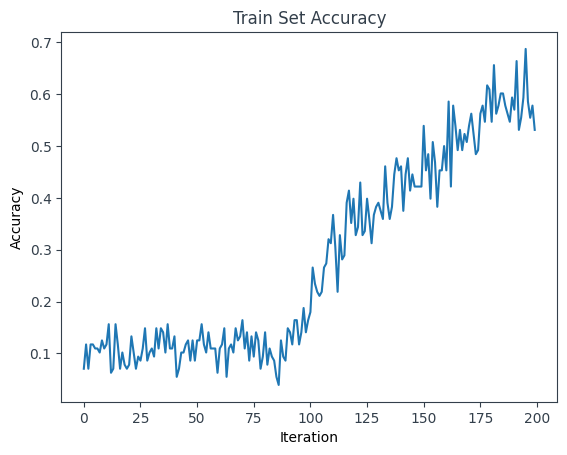

In [81]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

## 2.2 Evaluate the Network on the testset

In [82]:
# Assuming your model is already trained and stored in the variable 'net'
# Make sure your model is in evaluation mode
scnn_net.eval()

# Initialize variables to store predictions and ground truth labels
acc_hist = []

# Iterate over batches in the testloader
with torch.no_grad():
    for data, targets in testloader:
        # Move data and targets to the device (GPU or CPU)
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        spk_rec = forward_pass(scnn_net, data)

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)

        # if i%10 == 0:
        print(f"Accuracy: {acc * 100:.2f}%\n")

# Reset your model to training mode if needed
scnn_net.train()


Accuracy: 52.34%

Accuracy: 49.22%

Accuracy: 54.69%



Sequential(
  (0): Conv2d(2, 32, kernel_size=(4, 4), stride=(1, 1))
  (1): Leaky()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): Leaky()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=256, out_features=10, bias=True)
  (7): Leaky()
)

The average loss across the testloader is: 0.5208333333333334


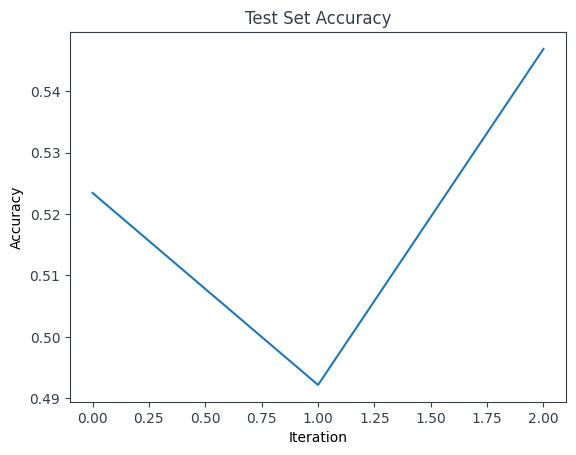

In [83]:
import matplotlib.pyplot as plt
import statistics

print("The average loss across the testloader is:", statistics.mean(acc_hist))
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

## 2.3 Visualize Spike Recordings

The following visual takes ~9 minutes to create. This visual is a spike count histogram that shows the spikes

In [84]:
spk_rec = forward_pass(scnn_net, data)

The target label is: 1


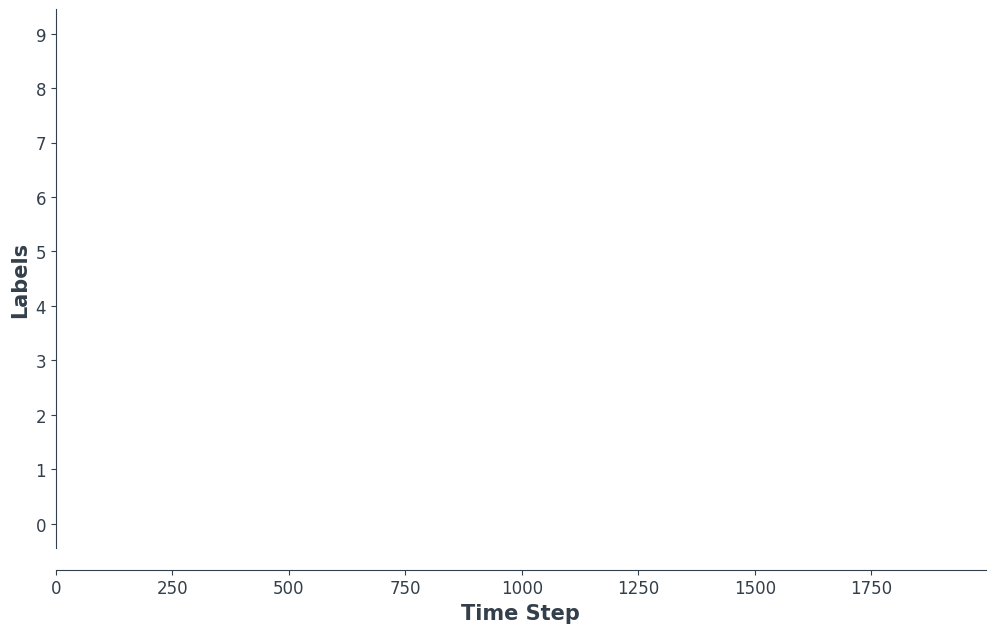

In [85]:
from IPython.display import HTML

start_time = time.time()

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=1)

display(HTML(anim.to_html5_video()))
# anim.save("spike_bar.mp4")

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to minutes, seconds, and milliseconds
minutes, seconds = divmod(elapsed_time, 60)
seconds, milliseconds = divmod(seconds, 1)
milliseconds = round(milliseconds * 1000)

In [86]:
# Print the result
print(f"Elapsed time: {int(minutes)} minutes, {int(seconds)} seconds, {milliseconds} milliseconds")

Elapsed time: 10 minutes, 43 seconds, 29 milliseconds


## 3 Run some Linear Networks for fun?

Below commented out are some Fully Connected Linear Networks of different depth feel free to also run if you want.

In [87]:
# # FCN Network Architecture
# num_inputs = 10*10*2
# num_hidden = 1000
# num_outputs = 10

# # fcsnn_net = nn.Sequential(nn.Linear(num_inputs, num_hidden),
# #                     snn.Leaky(beta=beta),
# #                     nn.Linear(num_hidden, num_hidden),
# #                     snn.Leaky(beta=beta),
# #                     nn.Linear(num_hidden, num_hidden),
# #                     snn.Leaky(beta=beta),
# #                     nn.Linear(num_hidden, num_hidden),
# #                     snn.Leaky(beta=beta),
# #                     nn.Linear(num_hidden, num_outputs),
# #                     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
# #                     ).to(device)

# fcsnn_net = nn.Sequential(nn.Flatten(),
#                     nn.Linear(num_inputs, num_hidden),
#                     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                     nn.Linear(num_hidden, num_outputs),
#                     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
#                     ).to(device)

# optimizer = torch.optim.Adam(fcsnn_net.parameters(), lr=2e-2, betas=(0.9, 0.999))
# loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [88]:
# num_epochs = 10
# num_iters = 50

# fcsnn_loss_hist = []
# fcsnn_acc_hist = []

# # training loop
# for epoch in range(num_epochs):
#     for i, (data, targets) in enumerate(iter(trainloader)):
#         data = data.to(device)
#         targets = targets.to(device)

#         fcsnn_net.train()
#         spk_rec = forward_pass(fcsnn_net, data)
#         loss_val = loss_fn(spk_rec, targets)

#         # Gradient calculation + weight update
#         optimizer.zero_grad()
#         loss_val.backward()
#         optimizer.step()

#         # Store loss history for future plotting
#         loss_hist.append(loss_val.item())

#         if i%4 == 0:
#             print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

#         acc = SF.accuracy_rate(spk_rec, targets)
#         acc_hist.append(acc)

#         if i%4 == 0:
#             print(f"Accuracy: {acc * 100:.2f}%\n")

#         # This will end training after 50 iterations by default
#         # if i == num_iters:
#         #   break

In [89]:
# import matplotlib.pyplot as plt

# # Plot Loss
# fig = plt.figure(facecolor="w")
# plt.plot(acc_hist)
# plt.title("Train Set Accuracy")
# plt.xlabel("Iteration")
# plt.ylabel("Accuracy")
# plt.show()

In [90]:
# fcsnn_net_seven_layers = nn.Sequential(nn.Flatten(),
#                         nn.Linear(num_inputs, num_hidden),
#                         snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                         nn.Linear(num_hidden, num_hidden),
#                         snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                         nn.Linear(num_hidden, num_hidden),
#                         snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                         nn.Linear(num_hidden, num_hidden),
#                         snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                         nn.Linear(num_hidden, num_hidden),
#                         snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                         nn.Linear(num_hidden, num_hidden),
#                         snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                         nn.Linear(num_hidden, num_outputs),
#                         snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
#                         ).to(device)

# optimizer = torch.optim.Adam(fcsnn_net_seven_layers.parameters(), lr=2e-2, betas=(0.9, 0.999))
# loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [91]:
# num_epochs = 10
# num_iters = 50

# fcsnn_loss_hist = []
# fcsnn_acc_hist = []

# # training loop
# for epoch in range(num_epochs):
#     for i, (data, targets) in enumerate(iter(trainloader)):
#         data = data.to(device)
#         targets = targets.to(device)

#         fcsnn_net_seven_layers.train()
#         spk_rec = forward_pass(fcsnn_net_seven_layers, data)
#         loss_val = loss_fn(spk_rec, targets)

#         # Gradient calculation + weight update
#         optimizer.zero_grad()
#         loss_val.backward()
#         optimizer.step()

#         # Store loss history for future plotting
#         loss_hist.append(loss_val.item())

#         if i%4 == 0:
#             print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

#         acc = SF.accuracy_rate(spk_rec, targets)
#         acc_hist.append(acc)

#         if i%4 == 0:
#             print(f"Accuracy: {acc * 100:.2f}%\n")

#         # This will end training after 50 iterations by default
#         # if i == num_iters:
#         #   break

In [92]:
# import matplotlib.pyplot as plt

# # Plot Loss
# fig = plt.figure(facecolor="w")
# plt.plot(acc_hist)
# plt.title("Train Set Accuracy")
# plt.xlabel("Iteration")
# plt.ylabel("Accuracy")
# plt.show()